Initially, we will use a simple Autoencoder. Later on, we might try the [Variational Autoencoder](https://arxiv.org/abs/1312.6114).

Note: you will find a lot of functions `fn()`. These functions are just meant to test if the code written is working as it should. I put the testing code inside these functions as I didn't want to waste the namespace.

In [1]:
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import torchinfo
from torchinfo import summary

from tensorflow.keras import datasets

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import pytz
from datetime import datetime
import time
import copy
# import glob
# import joblib
# import albumentations

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
# import seaborn as sns
# plt.style.use("fivethirtyeight")
# plt.style.use("default")

# import warnings
# warnings.filterwarnings("ignore")

%matplotlib inline
# %config InlineBackend.figure_format="svg"

print("Imports done!")

2024-03-19 09:20:10.845784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 09:20:10.845914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 09:20:11.010714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imports done!


## Load and Preprocess the data

In [2]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [4]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5,
                                                    shuffle=True, stratify=y_test,
                                                    random_state=42)

In [5]:
print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape,
      y_valid.shape, y_test.shape, sep='\n')

(60000, 32, 32, 1)
(5000, 32, 32, 1)
(5000, 32, 32, 1)
(60000,)
(5000,)
(5000,)


In [6]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

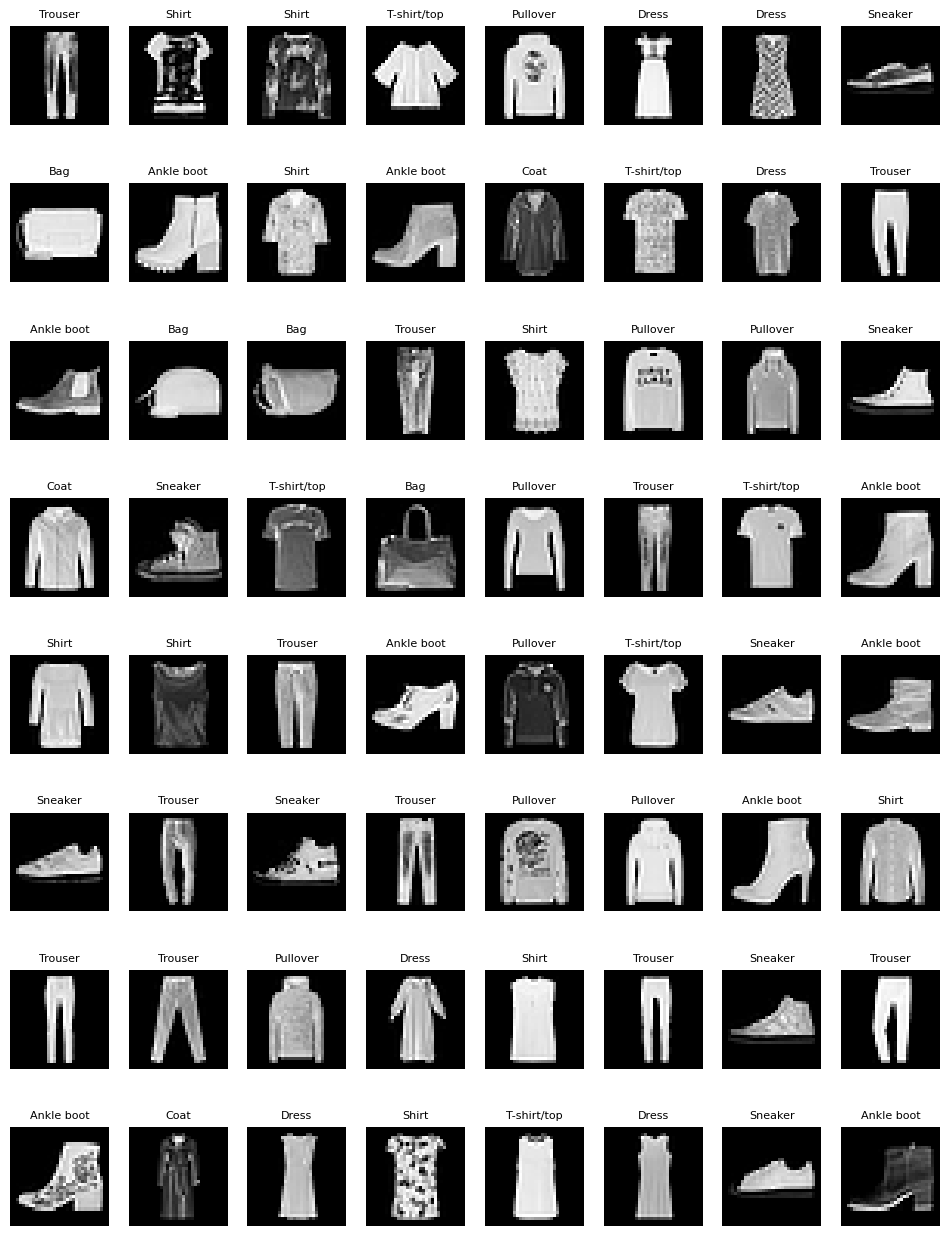

In [7]:
np.random.seed(42)

def visualize_data():
    nrows = 8
    ncols = 8
    indices = np.random.randint(low=0, high=60000, size=nrows*ncols).reshape(nrows,ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12,16))
    for i in range(nrows):
        for j in range(ncols):
            idx = indices[i][j]
            img = x_train[idx]
            label = class_labels[y_train[idx]]
            ax[i,j].imshow(img, cmap="gray")
            ax[i,j].set_title(label, fontsize=8)
            ax[i,j].axis("off")


visualize_data()

## PyTorch Model

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [9]:
class CustomDataset(Dataset):
    def __init__(self, features, targets, augmentations=None):
        self.features = features
        self.targets = targets
        self.augmentations = augmentations

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx, :]
        image = torch.tensor(image, dtype=torch.float32)
        label = self.targets[idx]
        label = torch.tensor(label, dtype=torch.long)
        if self.augmentations is not None:
            image = self.augmentations(image)
        return image, label


In [10]:
train_dataset = CustomDataset(features=x_train.reshape(60000, 1, 32, 32), targets=y_train)
valid_dataset = CustomDataset(features=x_valid.reshape(5000, 1, 32, 32), targets=y_valid)
test_dataset = CustomDataset(features=x_test.reshape(5000, 1, 32, 32), targets=y_test)

In [11]:

"""Helpful utility functions for PyTorch models."""


def set_dataloaders(batch_size=32):
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
                              # drop_last=True  # this will drop the last batch if its size is not 32
                              # pin_memory=True,
                              # num_workers=os.cpu_count())
    val_loader = DataLoader(valid_dataset,
                            batch_size=batch_size,
                            shuffle=False)
                            # drop_last=True  # this will drop the last batch if its size is not 32
                            # pin_memory=True,
                            # num_workers=os.cpu_count())
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
                             # drop_last=True  # this will drop the last batch if its size is not 32
                             # pin_memory=True,
                             # num_workers=os.cpu_count())
    return train_loader, val_loader, test_loader


def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if version of pytorch is =< 1.7, then use torch.set_deterministic(True)
        # else use torch.use_deterministic_algorithms(True)
        torch.use_deterministic_algorithms(True)
        
        
def compute_accuracy(y_pred, y):
    assert len(y_pred)==len(y), "length of y_pred and y must be equal"
    acc = torch.eq(y_pred, y).sum().item()
    acc /= len(y_pred)
    return acc
    

def train_step(model, dataloader, loss_fn, optimizer, device):
    """
    Processes just one training step, ie, just one epoch.
    To be used inside the main the training function.
    """
    # initialize the training loss and accuracy values of this entire batch to 0
    train_loss, train_acc = 0, 0
    # put the model in training mode
    model.train()
    # loop through the data loader batches
    for batch, (X, y) in enumerate(dataloader):
        # send both the X and y to device being used
        # we assume that the model is on this device already
        X = X.to(device)
        y = y.to(device)
        # forward pass
        logits = model(X)
        y_pred = torch.softmax(logits, dim=1)
        y_label = y_pred.argmax(dim=1)
        # calculate the loss and add it to the batch's training loss
        loss = loss_fn(logits, y)
        train_loss += loss.item()
        # calculate the accuracy and add it to the batch's training accuracy
        acc = compute_accuracy(y_label, y)
        train_acc += acc
        # zero the gradients of the optimizer so that they don't accumulate
        optimizer.zero_grad()
        # do a backward pass on the loss
        loss.backward()
        # update the optimizer (ie, update the gradients)
        optimizer.step()
    # calculate the average training loss and accuracy for this batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def train_step_gdl(model, dataloader, loss_fn, optimizer, device):
    """
    A variation of the original train_step function for generative deep
    learning models. Processes just one training step, ie, just one epoch.
    To be used inside the main the training function.
    """
    # initialize the training loss value of this entire batch to 0
    train_loss = 0
    # put the model in training mode
    model.train()
    # loop through the data loader batches
    for batch, (X, _) in enumerate(dataloader):
        # we don't need y, as the model is tested on how accurately it can 
        # reproduce the original image
        # send X the to device being used
        # we assume that the model is on this device already
        X = X.to(device)
        # forward pass
        reconstructed_img = model(X)
        # calculate the loss and add it to the batch's training loss
        loss = loss_fn(reconstructed_img, X)
        train_loss += loss.item()
        # zero the gradients of the optimizer so that they don't accumulate
        optimizer.zero_grad()
        # do a backward pass on the loss
        loss.backward()
        # update the optimizer (ie, update the gradients)
        optimizer.step()
    # calculate the average training loss for this batch
    train_loss /= len(dataloader)
    return train_loss


def validation_step(model, dataloader, loss_fn, device):
    """
    Processes just one step of validation, ie, just one batch.
    To be used inside the main training function.
    """
    # initialize the validation loss and accuracy values of this entire batch to 0
    val_loss, val_acc = 0, 0
    # put the model to evaluation mode
    model.eval()
    # turn on the inference context manager
    with torch.inference_mode():
        # loop through the dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send both X and y to the device being used
            # we assume that the model is on this device already
            X = X.to(device)
            y = y.to(device)
            # forward pass
            logits = model(X)
            y_pred = torch.softmax(logits, dim=1)
            y_label = y_pred.argmax(dim=1)
            # calculate the loss and add it to the batch's validation loss
            loss = loss_fn(logits, y)
            val_loss += loss.item()
            # calculate the accuracy and add it to the batch's validation accuracy
            acc = compute_accuracy(y_label, y)
            val_acc += acc
    # calculate the average validation loss and accuracy for this batch
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc


def validation_step_gdl(model, dataloader, loss_fn, device):
    """
    A variation of the original validation_step function for generative deep
    learning models. Processes just one validation step, ie, just one batch.
    To be used inside the main the training function.
    """
    # initialize the validation loss value of this entire batch to 0
    val_loss = 0
    # put the model to evaluation mode
    model.eval()
    # turn on the inference context manager
    with torch.inference_mode():
        # loop through the dataloader batches
        for batch, (X, _) in enumerate(dataloader):
            # we don't need y, as the model is tested on how accurately it can 
            # reproduce the original image
            # send X the to device being used
            # we assume that the model is on this device already
            X = X.to(device)
            # forward pass
            reconstructed_img = model(X)
            # calculate the loss and add it to the batch's validation loss
            loss = loss_fn(reconstructed_img, X)
            val_loss += loss.item()
    # calculate the average validation loss for this batch
    val_loss /= len(dataloader)
    return val_loss


def set_scheduler(scheduler, results, scheduler_on="val_acc"):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "val_acc":
        scheduler.step(results["val_acc"][-1])
    elif scheduler_on == "val_loss":
        scheduler.step(results["val_loss"][-1])
    elif scheduler_on == "train_acc":
        scheduler.step(results["train_acc"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def training_fn(model, train_loader, val_loader, loss_fn, optimizer, 
                epochs, device, scheduler=None, scheduler_on="val_acc"):
    """The main training function."""
    # create a results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    # loop through the training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # call the training function
        train_loss, train_acc = train_step(model, train_loader, loss_fn, 
                                           optimizer, device)
        # call the validation function
        val_loss, val_acc = validation_step(model, val_loader, loss_fn, device)
        # update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        if scheduler is not None:
            # adjust the learning rate
            scheduler = set_scheduler(scheduler, results, scheduler_on)
        # print out what's happening
        print(
            f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
            f"Train_acc: {train_acc:.5f} | Val_loss: {val_loss:.5f} | "
            f"Val_acc: {val_acc:.5f}"
        )
    return results


def training_fn_gdl(model, train_loader, val_loader, loss_fn, optimizer, 
                    epochs, device, scheduler=None, scheduler_on="val_loss"):
    """
    A variation of the main training_fn function for generative deep learning models.
    """
    # create a results dictionary
    results = {
        "train_loss": [],
        "val_loss": [],
    }
    # loop through the training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # call the training function
        train_loss = train_step_gdl(model, train_loader, loss_fn, optimizer, device)
        # call the validation function
        val_loss = validation_step_gdl(model, val_loader, loss_fn, device)
        # update the results dictionary
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
        if scheduler is not None:
            # adjust the learning rate
            scheduler = set_scheduler(scheduler, results, scheduler_on)
        # print out what's happening
        print(
            f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
            f"Val_loss: {val_loss:.5f}"
        )
    return results


def save_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), PATH/model_name)
    torch.save(optimizer.state_dict(), PATH/optimizer_name)
    if scheduler is not None:
        torch.save(scheduler.state_dict(), PATH/scheduler_name)    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(PATH/model_name))
    model.to(device)
    optimizer.load_state_dict(torch.load(PATH/optimizer_name))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(PATH/scheduler_name))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


def visualize_results(results):
    """Plot the training and validation loss and accuracy, given the results dictionary"""
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["val_loss"], results["val_acc"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    # ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].plot(x, train_loss, label="train_loss", color="orange")
    ax[0].plot(x, val_loss, label="val_loss", color="blue")
    ax[0].legend()
    # ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(x, train_acc, label="train_acc", color="orange")
    ax[1].plot(x, val_acc, label="val_acc", color="blue")
    ax[1].legend()
    plt.show()    
    

def visualize_results_gdl(results):
    """
    A variation of the original visualize_results function for generative deep 
    learning models. Plot the training and validation loss and accuracy, given 
    the results dictionary.
    """
    train_loss, val_loss = results["train_loss"], results["val_loss"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    plt.figure(figsize=(10,4))
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.plot(x, train_loss, label="train_loss", color="orange")
    plt.plot(x, val_loss, label="val_loss", color="blue")
    plt.legend()
    plt.show()
    
    

In [12]:
train_loader, val_loader, test_loader = set_dataloaders(128)

In [13]:
def fn():
    for X, y in train_loader:
        print(X.shape, y.shape)
        break
    pass

fn()

torch.Size([128, 1, 32, 32]) torch.Size([128])


In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=2048, out_features=2)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("After layer 1:\t", x.size())
        x = self.relu(self.conv2(x))
        # print("After layer 2:\t", x.size())
        x = self.relu(self.conv3(x))
        # print("After layer 3:\t", x.size())
        x = self.flatten(x)
        # print("After flatten:\t", x.size())
        x = self.linear1(x)
        return x
    


In [15]:
def fn():
    model = Encoder().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", X.shape)
        model(X)
        break
    pass

fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([128, 1, 32, 32])


In [16]:
def fn():
    model = Encoder().to(DEVICE)
    return summary(model=model, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [1, 1, 32, 32]       [1, 2]               --                   True
├─Conv2d (conv1)                         [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
├─ReLU (relu)                            [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
├─Conv2d (conv2)                         [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
├─ReLU (relu)                            [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
├─Conv2d (conv3)                         [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
├─ReLU (relu)                            [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
├─Flatten (flatten)                      [1, 128, 4, 4]       [1, 2048]            --                   --
├─Linear (linear1)    

In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=2048)
        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3,3),
                               stride=1, padding="same")
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.linear1(x)
        # print("After linear1:\t", x.size())
        x = x.view(-1, 128, 4, 4)  # does the work of the reshape layer in tensorflow
        # print("After reshaping:", x.size())
        x = self.relu(self.convt1(x))
        # print("After convt1:\t", x.size())
        x = self.relu(self.convt2(x))
        # print("After convt2:\t", x.size())
        x = self.relu(self.convt3(x))
        # print("After convt3:\t", x.size())
        x = self.sigmoid(self.conv1(x))
        # we use sigmoid because the input images are normalized to between 0 
        # and 1 and we want the decoder to also reconstruct the images such the 
        # pixels are between 0 and 1
        # if we had normalized the images to between -1 and 1, then we would
        # have used tanh instead of sigmoid
        # print("After conv1:\t", x.size())
        return x
        

In [18]:
def fn():
    model = Decoder().to(DEVICE)
    return summary(model=model, input_size=(1,2),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder (Decoder)                        [1, 2]               [1, 1, 32, 32]       --                   True
├─Linear (linear1)                       [1, 2]               [1, 2048]            6,144                True
├─ConvTranspose2d (convt1)               [1, 128, 4, 4]       [1, 128, 8, 8]       147,584              True
├─ReLU (relu)                            [1, 128, 8, 8]       [1, 128, 8, 8]       --                   --
├─ConvTranspose2d (convt2)               [1, 128, 8, 8]       [1, 64, 16, 16]      73,792               True
├─ReLU (relu)                            [1, 64, 16, 16]      [1, 64, 16, 16]      --                   --
├─ConvTranspose2d (convt3)               [1, 64, 16, 16]      [1, 32, 32, 32]      18,464               True
├─ReLU (relu)                            [1, 32, 32, 32]      [1, 32, 32, 32]      --                   --
├─Conv2d (conv1)    

In [19]:
def fn():
    encoder = Encoder().to(DEVICE)
    decoder = Decoder().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        enc_output = encoder(X)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", enc_output.shape, "---------->  embedding vector")
        decoder(enc_output)
        break
    pass

fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([128, 2]) ---------->  embedding vector


In [20]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [21]:
def fn():
    enc = Encoder().to(DEVICE)
    dec = Decoder().to(DEVICE)
    autoencoder = AutoEncoder(enc, dec).to(DEVICE)
    return summary(model=autoencoder, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AutoEncoder (AutoEncoder)                [1, 1, 32, 32]       [1, 1, 32, 32]       --                   True
├─Encoder (encoder)                      [1, 1, 32, 32]       [1, 2]               --                   True
│    └─Conv2d (conv1)                    [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
│    └─ReLU (relu)                       [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Conv2d (conv2)                    [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
│    └─ReLU (relu)                       [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                    [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
│    └─ReLU (relu)                       [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
│    └─Flatten (flat

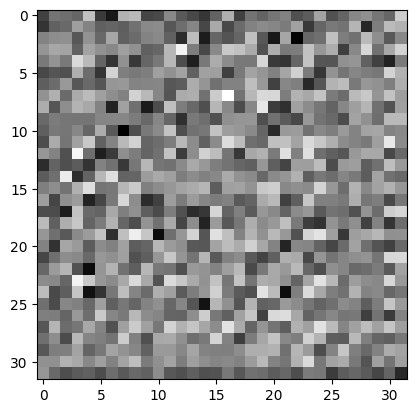

In [22]:
def fn():
    encoder = Encoder().to(DEVICE)
    decoder = Decoder().to(DEVICE)
    autoencoder = AutoEncoder(encoder, decoder).to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        output = autoencoder(X)
        if "cuda" in DEVICE:
            plt.imshow(output[0].squeeze(axis=0).cpu().detach().numpy(), cmap='gray')
        else:
            plt.imshow(output[0].squeeze(axis=0).cpu().detach().numpy(), cmap='gray')
        break
    pass

fn()

In [23]:
train_loader, val_loader, test_loader = set_dataloaders(64)

ae1 = AutoEncoder(Encoder(), Decoder()).to(DEVICE)
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=ae1.parameters(), lr=3e-4)

results = training_fn_gdl(model=ae1, train_loader=train_loader, val_loader=val_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=24, device=DEVICE)

  4%|▍         | 1/24 [01:44<39:57, 104.22s/it]

Epoch: 1 | Train_loss: 0.04026 | Val_loss: 0.02746


  8%|▊         | 2/24 [03:30<38:34, 105.19s/it]

Epoch: 2 | Train_loss: 0.02658 | Val_loss: 0.02534


 12%|█▎        | 3/24 [05:21<37:53, 108.24s/it]

Epoch: 3 | Train_loss: 0.02494 | Val_loss: 0.02435


 17%|█▋        | 4/24 [07:19<37:19, 111.95s/it]

Epoch: 4 | Train_loss: 0.02408 | Val_loss: 0.02371


 21%|██        | 5/24 [09:13<35:41, 112.71s/it]

Epoch: 5 | Train_loss: 0.02350 | Val_loss: 0.02331


 25%|██▌       | 6/24 [11:09<34:06, 113.69s/it]

Epoch: 6 | Train_loss: 0.02311 | Val_loss: 0.02262


 29%|██▉       | 7/24 [13:04<32:21, 114.23s/it]

Epoch: 7 | Train_loss: 0.02275 | Val_loss: 0.02277


 33%|███▎      | 8/24 [14:58<30:25, 114.10s/it]

Epoch: 8 | Train_loss: 0.02249 | Val_loss: 0.02250


 38%|███▊      | 9/24 [16:57<28:53, 115.56s/it]

Epoch: 9 | Train_loss: 0.02219 | Val_loss: 0.02207


 42%|████▏     | 10/24 [18:52<26:56, 115.48s/it]

Epoch: 10 | Train_loss: 0.02201 | Val_loss: 0.02204


 46%|████▌     | 11/24 [20:48<25:03, 115.62s/it]

Epoch: 11 | Train_loss: 0.02182 | Val_loss: 0.02187


 50%|█████     | 12/24 [22:42<23:03, 115.27s/it]

Epoch: 12 | Train_loss: 0.02166 | Val_loss: 0.02170


 54%|█████▍    | 13/24 [24:35<20:59, 114.50s/it]

Epoch: 13 | Train_loss: 0.02151 | Val_loss: 0.02145


 58%|█████▊    | 14/24 [26:31<19:09, 114.95s/it]

Epoch: 14 | Train_loss: 0.02139 | Val_loss: 0.02185


 62%|██████▎   | 15/24 [28:26<17:15, 115.02s/it]

Epoch: 15 | Train_loss: 0.02124 | Val_loss: 0.02197


 67%|██████▋   | 16/24 [30:24<15:26, 115.77s/it]

Epoch: 16 | Train_loss: 0.02112 | Val_loss: 0.02119


 71%|███████   | 17/24 [32:24<13:39, 117.04s/it]

Epoch: 17 | Train_loss: 0.02102 | Val_loss: 0.02112


 75%|███████▌  | 18/24 [34:21<11:42, 117.01s/it]

Epoch: 18 | Train_loss: 0.02090 | Val_loss: 0.02096


 79%|███████▉  | 19/24 [36:19<09:46, 117.33s/it]

Epoch: 19 | Train_loss: 0.02080 | Val_loss: 0.02097


 83%|████████▎ | 20/24 [38:16<07:49, 117.36s/it]

Epoch: 20 | Train_loss: 0.02070 | Val_loss: 0.02106


 88%|████████▊ | 21/24 [40:12<05:50, 116.92s/it]

Epoch: 21 | Train_loss: 0.02060 | Val_loss: 0.02103


 92%|█████████▏| 22/24 [42:12<03:55, 117.69s/it]

Epoch: 22 | Train_loss: 0.02058 | Val_loss: 0.02087


 96%|█████████▌| 23/24 [44:09<01:57, 117.56s/it]

Epoch: 23 | Train_loss: 0.02047 | Val_loss: 0.02068


100%|██████████| 24/24 [46:07<00:00, 115.31s/it]

Epoch: 24 | Train_loss: 0.02041 | Val_loss: 0.02065


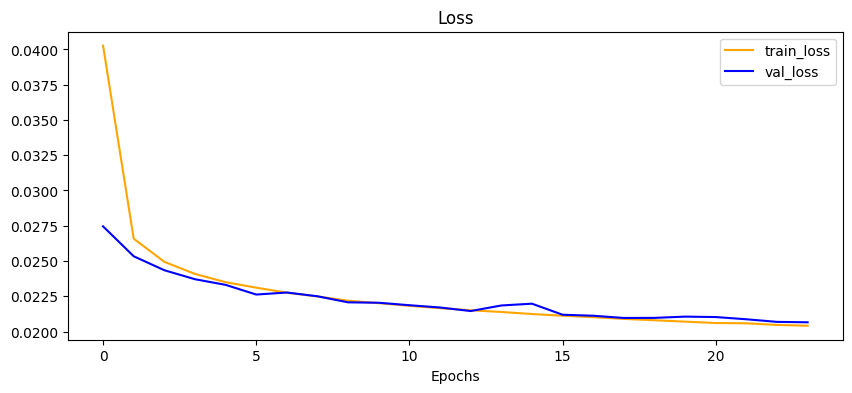

In [24]:
visualize_results_gdl(results)

## Visualizing the 2-dimensional latent space

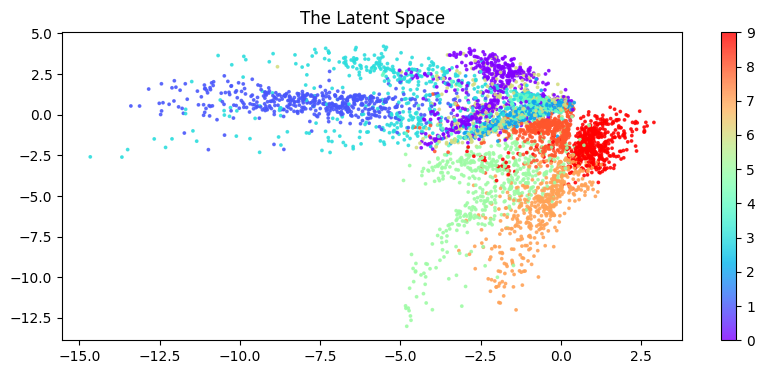

In [25]:
# Visualize the latent space

def visualize_latent_space(model, return_embeddings=False):
    embeddings = []
    labels = []
    model.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(DEVICE)
            preds = model.encoder(X)
            preds = preds.cpu().detach().numpy()
            embeddings.append(preds)
            labels.append(y.cpu().detach().numpy())
    last_batch_embeddings = np.array(embeddings[-1])
    embeddings.pop()
    embeddings = np.array(embeddings).reshape(-1, 2)
    last_batch_labels = np.array(labels[-1])
    labels.pop()
    labels = np.array(labels).flatten()
    if return_embeddings:
        return embeddings, labels
    else:
        plt.figure(figsize=(10,4))
        plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap="rainbow", 
                    c=labels, alpha=0.8, s=3)
        plt.title("The Latent Space")
        plt.colorbar()
        plt.show()

    
visualize_latent_space(model=ae1)

## Reconstructing some images

In [26]:
def predict_torch_gdl(model, img, device):
    """
    This funtion assumes that img is a 4d tensor, ie, (N, C, H, W).
    If img is a single image, then the dimension should be (1, C, H, W).
    """
    model.eval()
    with torch.inference_mode():
        reconstructed_img = model(img)
    reconstructed_img = reconstructed_img.squeeze(dim=0)
    img = img.squeeze(dim=0)
    if "cuda" in device:
        reconstructed_img = reconstructed_img.cpu().detach().numpy().reshape(32, 32, 1)
        img = img.cpu().detach().numpy().reshape(32, 32, 1)
    else:
        reconstructed_img = reconstructed_img.detach().numpy().reshape(32, 32, 1)
        img = img.detach().numpy().reshape(32, 32, 1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].set_title("Original")
    ax[0].imshow(img, cmap="gray")
    ax[1].set_title("Reconstructed Image")
    ax[1].imshow(reconstructed_img, cmap="gray")
    plt.show()
    

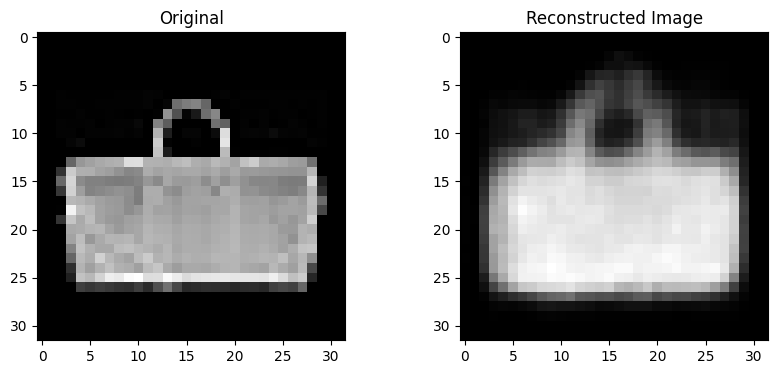

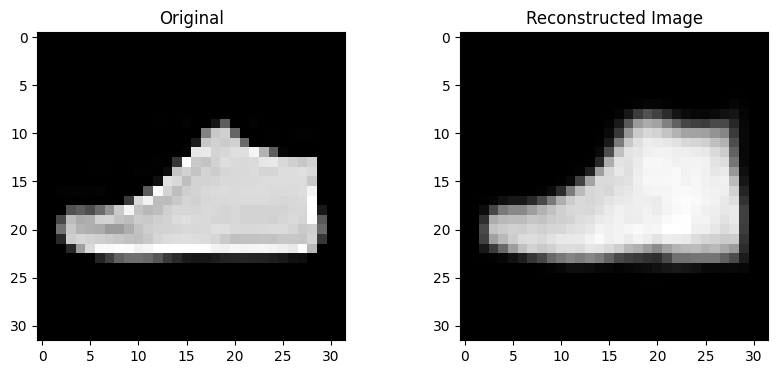

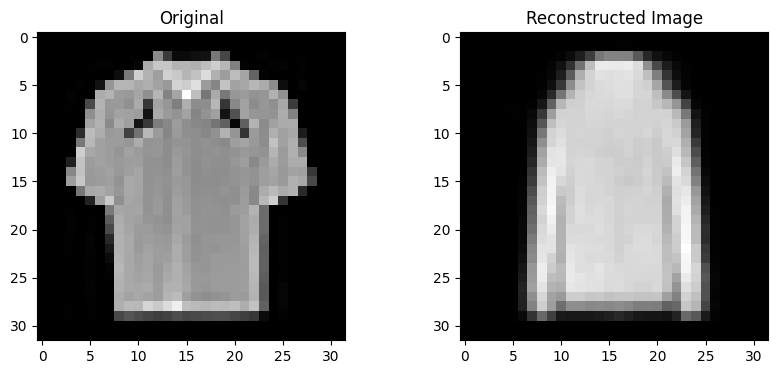

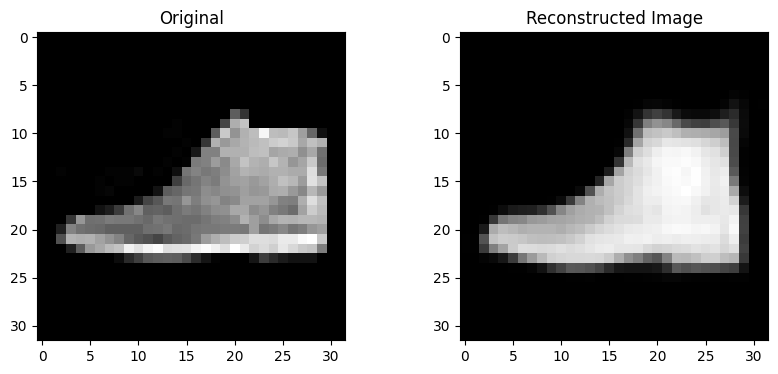

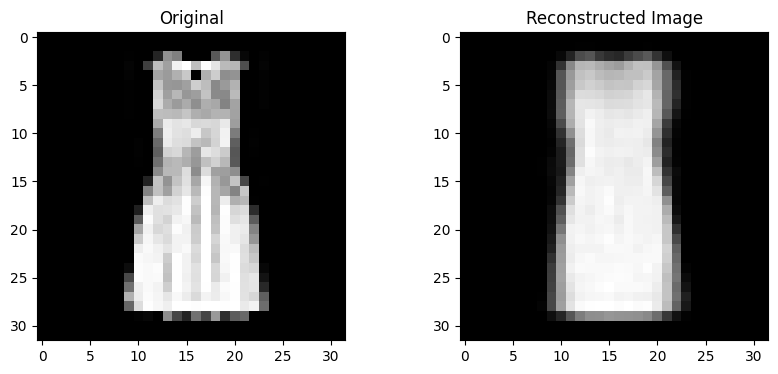

In [27]:
def fn():
    idx = 0
    for X,y in test_loader:
        if idx == 5:
            break
        X = X.to(DEVICE)
        img = X[idx].unsqueeze(dim=0)
        predict_torch_gdl(ae1, img, DEVICE)
        idx += 1
    pass

fn()

## Creating a better model (increasing the latent space to 32-dimensions)

By doing this, we are increasing the ability of the latent space to store more information.

In [28]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=2048, out_features=32)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("After layer 1:\t", x.size())
        x = self.relu(self.conv2(x))
        # print("After layer 2:\t", x.size())
        x = self.relu(self.conv3(x))
        # print("After layer 3:\t", x.size())
        x = self.flatten(x)
        # print("After flatten:\t", x.size())
        x = self.linear1(x)
        return x
    


In [29]:
class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.linear1 = nn.Linear(in_features=32, out_features=2048)
        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3,3),
                               stride=1, padding="same")
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.linear1(x)
        # print("After linear1:\t", x.size())
        x = x.view(-1, 128, 4, 4)  # does the work of the reshape layer in tensorflow
        # print("After reshaping:", x.size())
        x = self.relu(self.convt1(x))
        # print("After convt1:\t", x.size())
        x = self.relu(self.convt2(x))
        # print("After convt2:\t", x.size())
        x = self.relu(self.convt3(x))
        # print("After convt3:\t", x.size())
        x = self.sigmoid(self.conv1(x))
        # we use sigmoid because the input images are normalized to between 0 
        # and 1 and we want the decoder to also reconstruct the images such the 
        # pixels are between 0 and 1
        # if we had normalized the images to between -1 and 1, then we would
        # have used tanh instead of sigmoid
        # print("After conv1:\t", x.size())
        return x
        

In [30]:
def fn():
    enc = Encoder2().to(DEVICE)
    dec = Decoder2().to(DEVICE)
    autoencoder = AutoEncoder(enc, dec).to(DEVICE)
    return summary(model=autoencoder, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AutoEncoder (AutoEncoder)                [1, 1, 32, 32]       [1, 1, 32, 32]       --                   True
├─Encoder2 (encoder)                     [1, 1, 32, 32]       [1, 32]              --                   True
│    └─Conv2d (conv1)                    [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
│    └─ReLU (relu)                       [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Conv2d (conv2)                    [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
│    └─ReLU (relu)                       [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                    [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
│    └─ReLU (relu)                       [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
│    └─Flatten (flat

In [31]:
train_loader, val_loader, test_loader = set_dataloaders(64)

ae2 = AutoEncoder(Encoder2(), Decoder2()).to(DEVICE)
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=ae2.parameters(), lr=3e-4)

results = training_fn_gdl(model=ae2, train_loader=train_loader, val_loader=val_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=24, device=DEVICE)

  4%|▍         | 1/24 [01:50<42:31, 110.95s/it]

Epoch: 1 | Train_loss: 0.02988 | Val_loss: 0.01293


  8%|▊         | 2/24 [04:45<54:22, 148.28s/it]

Epoch: 2 | Train_loss: 0.01114 | Val_loss: 0.00984


 12%|█▎        | 3/24 [08:28<1:03:52, 182.48s/it]

Epoch: 3 | Train_loss: 0.00896 | Val_loss: 0.00829


 17%|█▋        | 4/24 [12:28<1:08:21, 205.09s/it]

Epoch: 4 | Train_loss: 0.00782 | Val_loss: 0.00741


 21%|██        | 5/24 [16:31<1:09:15, 218.72s/it]

Epoch: 5 | Train_loss: 0.00714 | Val_loss: 0.00692


 25%|██▌       | 6/24 [20:39<1:08:39, 228.87s/it]

Epoch: 6 | Train_loss: 0.00668 | Val_loss: 0.00654


 29%|██▉       | 7/24 [24:49<1:06:48, 235.82s/it]

Epoch: 7 | Train_loss: 0.00634 | Val_loss: 0.00637


 33%|███▎      | 8/24 [29:08<1:04:50, 243.15s/it]

Epoch: 8 | Train_loss: 0.00610 | Val_loss: 0.00607


 38%|███▊      | 9/24 [33:23<1:01:43, 246.90s/it]

Epoch: 9 | Train_loss: 0.00592 | Val_loss: 0.00590


 42%|████▏     | 10/24 [37:35<57:55, 248.28s/it] 

Epoch: 10 | Train_loss: 0.00576 | Val_loss: 0.00583


 46%|████▌     | 11/24 [41:44<53:53, 248.71s/it]

Epoch: 11 | Train_loss: 0.00564 | Val_loss: 0.00575


 50%|█████     | 12/24 [45:48<49:27, 247.26s/it]

Epoch: 12 | Train_loss: 0.00554 | Val_loss: 0.00564


 54%|█████▍    | 13/24 [49:48<44:53, 244.83s/it]

Epoch: 13 | Train_loss: 0.00545 | Val_loss: 0.00556


 58%|█████▊    | 14/24 [53:47<40:30, 243.05s/it]

Epoch: 14 | Train_loss: 0.00536 | Val_loss: 0.00550


 62%|██████▎   | 15/24 [57:39<35:58, 239.79s/it]

Epoch: 15 | Train_loss: 0.00530 | Val_loss: 0.00547


 67%|██████▋   | 16/24 [1:01:25<31:25, 235.70s/it]

Epoch: 16 | Train_loss: 0.00523 | Val_loss: 0.00534


 71%|███████   | 17/24 [1:05:07<27:01, 231.67s/it]

Epoch: 17 | Train_loss: 0.00518 | Val_loss: 0.00531


 75%|███████▌  | 18/24 [1:08:45<22:45, 227.56s/it]

Epoch: 18 | Train_loss: 0.00513 | Val_loss: 0.00524


 79%|███████▉  | 19/24 [1:12:23<18:43, 224.68s/it]

Epoch: 19 | Train_loss: 0.00508 | Val_loss: 0.00524


 83%|████████▎ | 20/24 [1:15:57<14:45, 221.44s/it]

Epoch: 20 | Train_loss: 0.00503 | Val_loss: 0.00520


 88%|████████▊ | 21/24 [1:19:29<10:55, 218.51s/it]

Epoch: 21 | Train_loss: 0.00499 | Val_loss: 0.00517


 92%|█████████▏| 22/24 [1:22:58<07:11, 215.77s/it]

Epoch: 22 | Train_loss: 0.00496 | Val_loss: 0.00513


 96%|█████████▌| 23/24 [1:26:29<03:34, 214.29s/it]

Epoch: 23 | Train_loss: 0.00492 | Val_loss: 0.00508


100%|██████████| 24/24 [1:29:54<00:00, 224.78s/it]

Epoch: 24 | Train_loss: 0.00489 | Val_loss: 0.00509


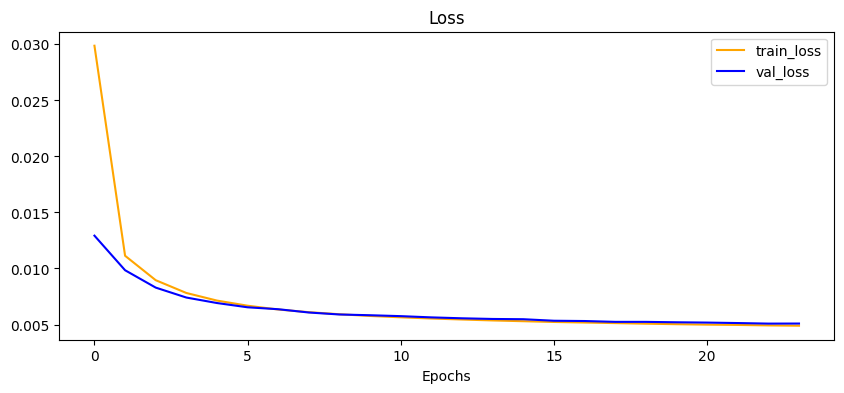

In [32]:
visualize_results_gdl(results)

## Reconstructing some images

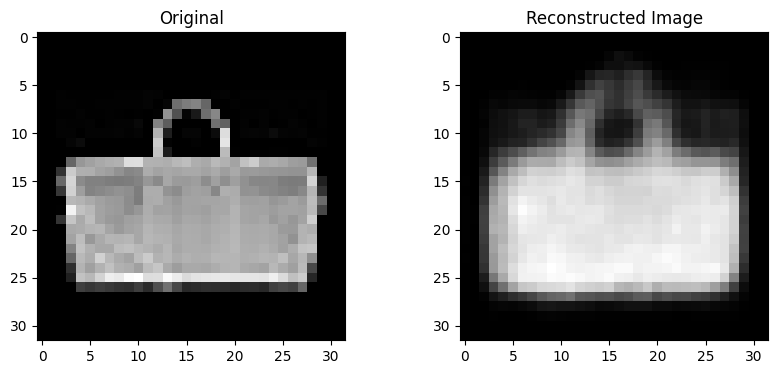

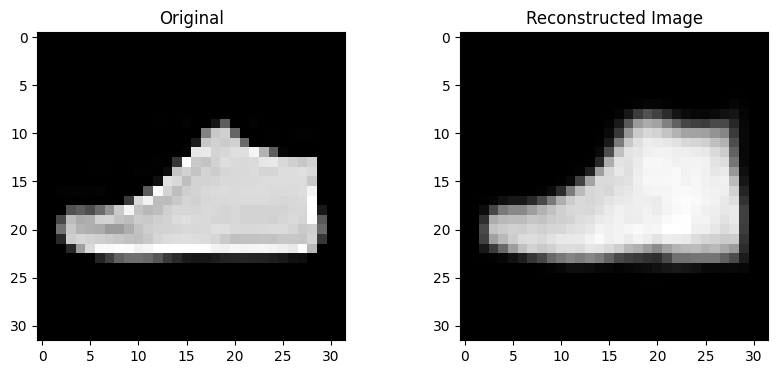

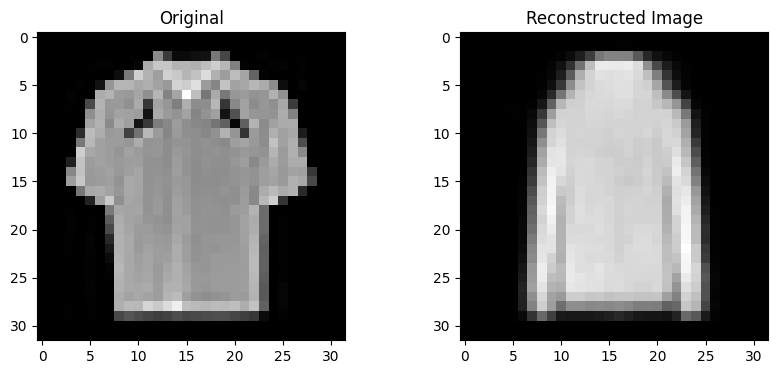

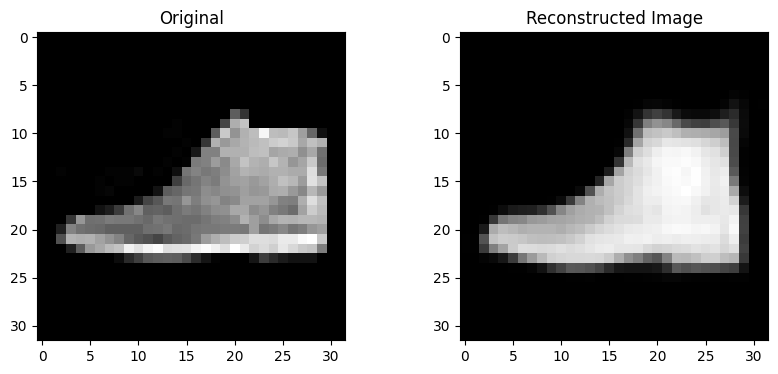

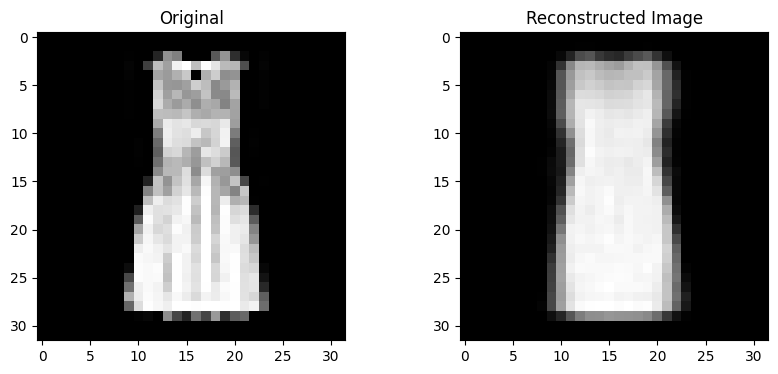

In [33]:
def fn():
    idx = 0
    for X,y in test_loader:
        if idx == 5:
            break
        X = X.to(DEVICE)
        img = X[idx].unsqueeze(dim=0)
        predict_torch_gdl(ae1, img, DEVICE)
        idx += 1
    pass

fn()

# Building a classifier by freezing encoder's weights

In [34]:
class Classifier1(nn.Module):
    def __init__(self, model):
        super(Classifier1, self).__init__()
        self.encoder = copy.deepcopy(model.encoder)
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.classifier_head = nn.Sequential(
            nn.Linear(32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        latent_space_embedding = self.encoder(x)
        x = self.classifier_head(latent_space_embedding)
        return x
    

In [35]:
def fn():
    model = Classifier1(ae2).to(DEVICE)
    return summary(model=model, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Classifier1 (Classifier1)                [1, 1, 32, 32]       [1, 10]              --                   Partial
├─Encoder2 (encoder)                     [1, 1, 32, 32]       [1, 32]              --                   False
│    └─Conv2d (conv1)                    [1, 1, 32, 32]       [1, 32, 16, 16]      (320)                False
│    └─ReLU (relu)                       [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Conv2d (conv2)                    [1, 32, 16, 16]      [1, 64, 8, 8]        (18,496)             False
│    └─ReLU (relu)                       [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                    [1, 64, 8, 8]        [1, 128, 4, 4]       (73,856)             False
│    └─ReLU (relu)                       [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
│    └─Flatte

In [36]:
def fn():
    model = Classifier1(ae2).to(DEVICE)
    for X, y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        pred = torch.softmax(model(X), dim=1).argmax(dim=1)
        print(pred[0], y[0], sep='\n')
        break
    
fn()

tensor(7)
tensor(8)


In [37]:
classifier_model1 = Classifier1(ae2).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=classifier_model1.parameters(), lr=3e-4)

results = training_fn(model=classifier_model1, train_loader=train_loader, val_loader=val_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=24, device=DEVICE)

  4%|▍         | 1/24 [00:13<05:19, 13.88s/it]

Epoch: 1 | Train_loss: 0.40652 | Train_acc: 0.85203 | Val_loss: 0.35479 | Val_acc: 0.86966


  8%|▊         | 2/24 [00:27<05:02, 13.73s/it]

Epoch: 2 | Train_loss: 0.30507 | Train_acc: 0.88763 | Val_loss: 0.34023 | Val_acc: 0.87737


 12%|█▎        | 3/24 [00:41<04:53, 13.96s/it]

Epoch: 3 | Train_loss: 0.27623 | Train_acc: 0.89687 | Val_loss: 0.33385 | Val_acc: 0.88014


 17%|█▋        | 4/24 [00:55<04:38, 13.92s/it]

Epoch: 4 | Train_loss: 0.25574 | Train_acc: 0.90397 | Val_loss: 0.31344 | Val_acc: 0.88528


 21%|██        | 5/24 [01:09<04:26, 14.03s/it]

Epoch: 5 | Train_loss: 0.24012 | Train_acc: 0.90971 | Val_loss: 0.30147 | Val_acc: 0.88489


 25%|██▌       | 6/24 [01:23<04:10, 13.91s/it]

Epoch: 6 | Train_loss: 0.22162 | Train_acc: 0.91586 | Val_loss: 0.30357 | Val_acc: 0.88766


 29%|██▉       | 7/24 [01:37<03:55, 13.84s/it]

Epoch: 7 | Train_loss: 0.20758 | Train_acc: 0.92163 | Val_loss: 0.28900 | Val_acc: 0.89636


 33%|███▎      | 8/24 [01:50<03:40, 13.77s/it]

Epoch: 8 | Train_loss: 0.19360 | Train_acc: 0.92606 | Val_loss: 0.29446 | Val_acc: 0.89972


 38%|███▊      | 9/24 [02:04<03:24, 13.61s/it]

Epoch: 9 | Train_loss: 0.17774 | Train_acc: 0.93320 | Val_loss: 0.31245 | Val_acc: 0.89161


 42%|████▏     | 10/24 [02:17<03:11, 13.66s/it]

Epoch: 10 | Train_loss: 0.16488 | Train_acc: 0.93747 | Val_loss: 0.31795 | Val_acc: 0.88706


 46%|████▌     | 11/24 [02:31<02:56, 13.57s/it]

Epoch: 11 | Train_loss: 0.15385 | Train_acc: 0.94091 | Val_loss: 0.31302 | Val_acc: 0.89814


 50%|█████     | 12/24 [02:44<02:43, 13.63s/it]

Epoch: 12 | Train_loss: 0.13959 | Train_acc: 0.94583 | Val_loss: 0.31526 | Val_acc: 0.89537


 54%|█████▍    | 13/24 [02:58<02:28, 13.51s/it]

Epoch: 13 | Train_loss: 0.12720 | Train_acc: 0.95054 | Val_loss: 0.31515 | Val_acc: 0.89834


 58%|█████▊    | 14/24 [03:11<02:14, 13.41s/it]

Epoch: 14 | Train_loss: 0.11585 | Train_acc: 0.95634 | Val_loss: 0.33012 | Val_acc: 0.89794


 62%|██████▎   | 15/24 [03:25<02:01, 13.49s/it]

Epoch: 15 | Train_loss: 0.10359 | Train_acc: 0.95984 | Val_loss: 0.36487 | Val_acc: 0.89616


 67%|██████▋   | 16/24 [03:38<01:47, 13.44s/it]

Epoch: 16 | Train_loss: 0.09647 | Train_acc: 0.96322 | Val_loss: 0.38838 | Val_acc: 0.89359


 71%|███████   | 17/24 [03:52<01:34, 13.56s/it]

Epoch: 17 | Train_loss: 0.08452 | Train_acc: 0.96797 | Val_loss: 0.40147 | Val_acc: 0.89755


 75%|███████▌  | 18/24 [04:05<01:20, 13.47s/it]

Epoch: 18 | Train_loss: 0.07402 | Train_acc: 0.97188 | Val_loss: 0.41484 | Val_acc: 0.89557


 79%|███████▉  | 19/24 [04:19<01:07, 13.52s/it]

Epoch: 19 | Train_loss: 0.06660 | Train_acc: 0.97413 | Val_loss: 0.44983 | Val_acc: 0.89597


 83%|████████▎ | 20/24 [04:32<00:53, 13.38s/it]

Epoch: 20 | Train_loss: 0.06575 | Train_acc: 0.97455 | Val_loss: 0.46046 | Val_acc: 0.89082


 88%|████████▊ | 21/24 [04:45<00:39, 13.24s/it]

Epoch: 21 | Train_loss: 0.05523 | Train_acc: 0.97894 | Val_loss: 0.45789 | Val_acc: 0.89616


 92%|█████████▏| 22/24 [04:58<00:26, 13.33s/it]

Epoch: 22 | Train_loss: 0.05150 | Train_acc: 0.98094 | Val_loss: 0.46657 | Val_acc: 0.89478


 96%|█████████▌| 23/24 [05:11<00:13, 13.19s/it]

Epoch: 23 | Train_loss: 0.04407 | Train_acc: 0.98388 | Val_loss: 0.51451 | Val_acc: 0.89834


100%|██████████| 24/24 [05:25<00:00, 13.55s/it]

Epoch: 24 | Train_loss: 0.04740 | Train_acc: 0.98256 | Val_loss: 0.51681 | Val_acc: 0.89221


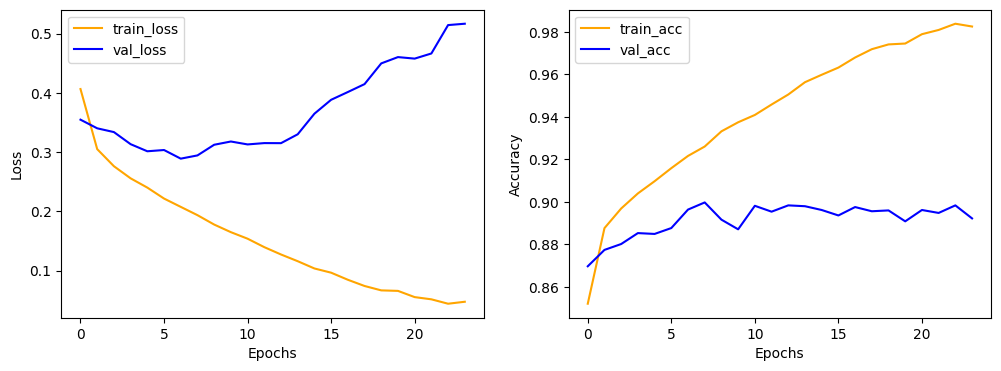

In [38]:
visualize_results(results)

## Making some prediction using the classifier

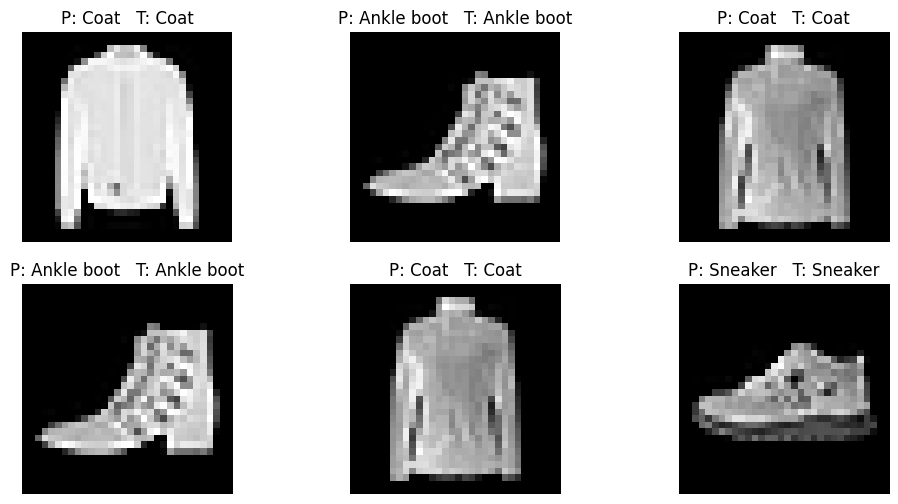

In [39]:
def predict_classifier(model, device):
    model.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            preds = torch.softmax(model(X), dim=1).argmax(dim=1)
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
    preds = preds.squeeze(axis=0).cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    X = X.cpu().detach().numpy()
    for i in range(2):
        for j in range(3):
            pred_label = class_labels[preds[i+j]]
            y_label = class_labels[y[i+j]]
            ax[i,j].set_title(f"P: {pred_label}   T: {y_label}")
            ax[i,j].imshow(X[i+j].squeeze(axis=0), cmap="gray")
            ax[i,j].axis("off")
    pass


predict_classifier(classifier_model1, DEVICE)